In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%%time
import dataset_helper
import preprocessing
import graph_helper
import cooccurrence
from joblib import Parallel, delayed
import networkx as nx

for dataset in dataset_helper.get_all_available_dataset_names():
    print("Creating co-occurence graphs for: {}".format(dataset))
    cache_file = dataset_helper.CACHE_PATH + '/dataset_graph_cooccurrence_{}.npy'.format(dataset)
    X, Y = dataset_helper.get_dataset(dataset, preprocessed = False, use_cached=True, transform_fn=graph_helper.convert_dataset_to_co_occurence_graph_dataset, cache_file=cache_file)

In [ ]:
%%time
for dataset in ['reuters-21578-single', 'webkb-single', 'ng20-single', 'ling-spam-single']:
    print('Starting dataset: {}'.format(dataset))
    X, Y = dataset_helper.get_gml_graph_dataset(dataset)

In [ ]:
from joblib import Parallel, delayed

from time import time
phi_list_train_last = phi_list_train[-1]
test_graphs = train[:100]

def test_graph(idx, a):
    topic, graph = a
    #if idx % 1 == 0: print('{:>8}/{}'.format(idx, len(test_graphs)))
    phi_train = wl.compute_phi(graph, phi_list_train_last.shape, label_lookup_train, label_counters_train, h = 1)
    for i, (real, new) in enumerate(zip(phi_list_train, phi_train)):
        real = real[:,idx]
        new = lil_matrix(new.reshape(-1,1))
        if not np.array_equiv(real.nonzero()[0], new.nonzero()[0]):
            print('Phi not equal', i, 'Real', real, '\nNew\n', new)
    print('Finished: {}'.format(idx))
    
mats = Parallel(n_jobs=2)(delayed(test_graph)(*d) for d in list(enumerate(test_graphs)))

for idx, (topic, graph) in enumerate(test_graphs):
    break
    if idx % 1 == 0: print('{:>8}/{}'.format(idx, len(test_graphs)))
    phi_train = wl.compute_phi(graph, phi_list_train_last.shape, label_lookup_train, label_counters_train, h = 1)
    for i, (real, new) in enumerate(zip(real_, phi_train)):
        real = real[:,idx]
        new = lil_matrix(new.reshape(-1,1))
        if not np.array_equiv(real.nonzero()[0], new.nonzero()[0]):
            print('Phi not equal', i, 'Real', real, '\nNew\n', new)
            break


Getting dataset: ling-spam


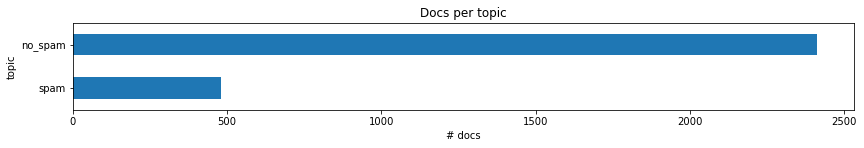

Getting dataset: reuters-21578


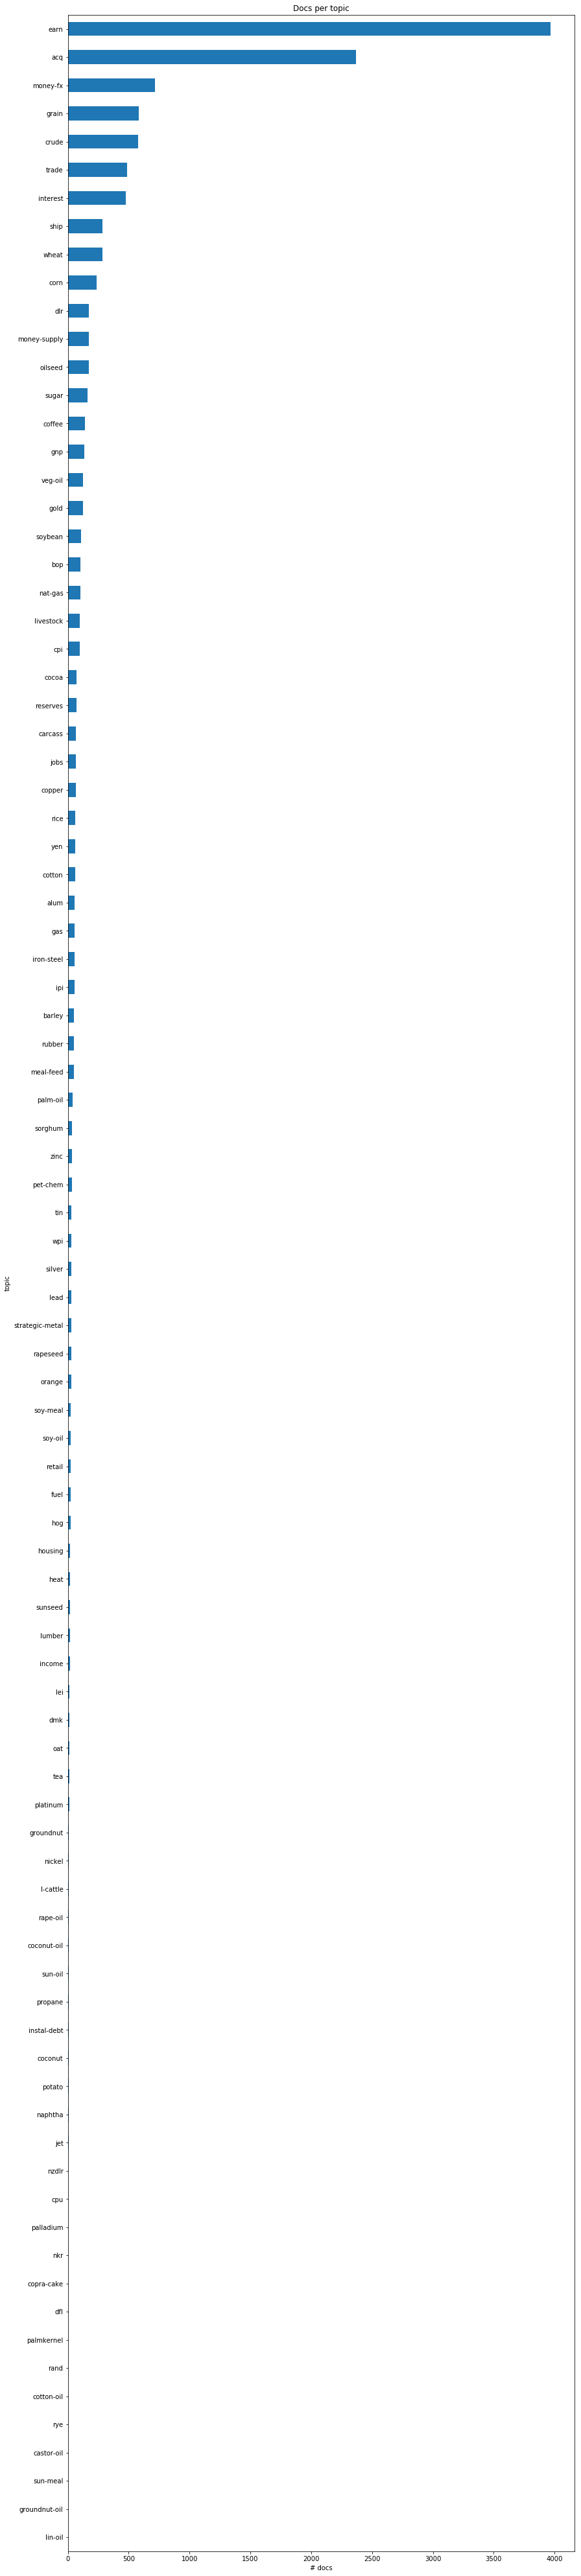

Getting dataset: webkb


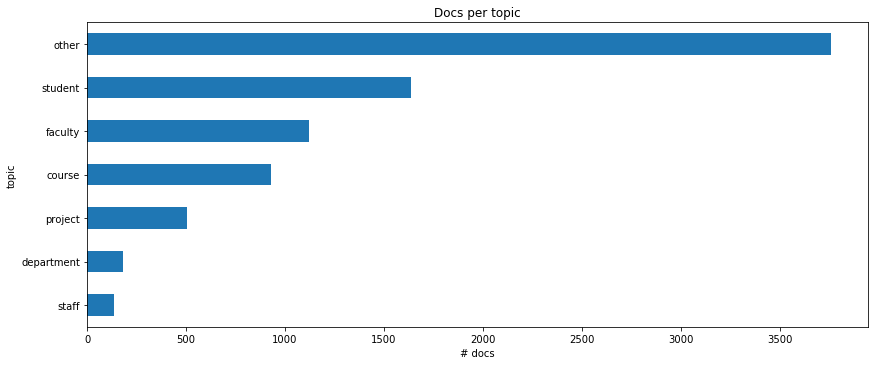

Getting dataset: cade-ana


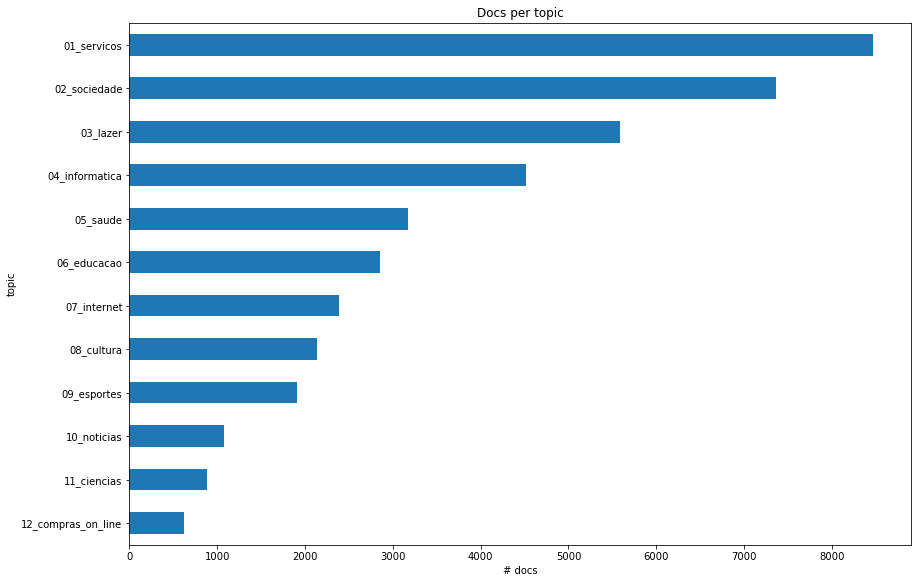

Getting dataset: mini20-ana


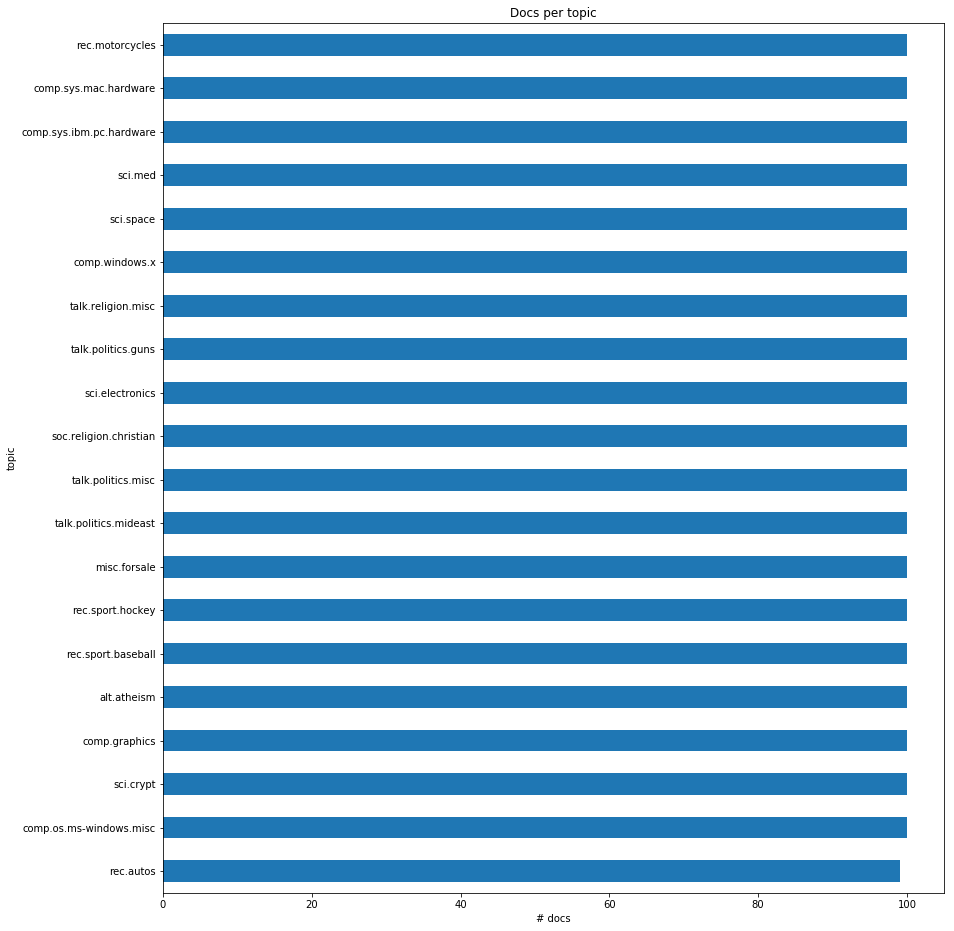

Getting dataset: ng20-ana


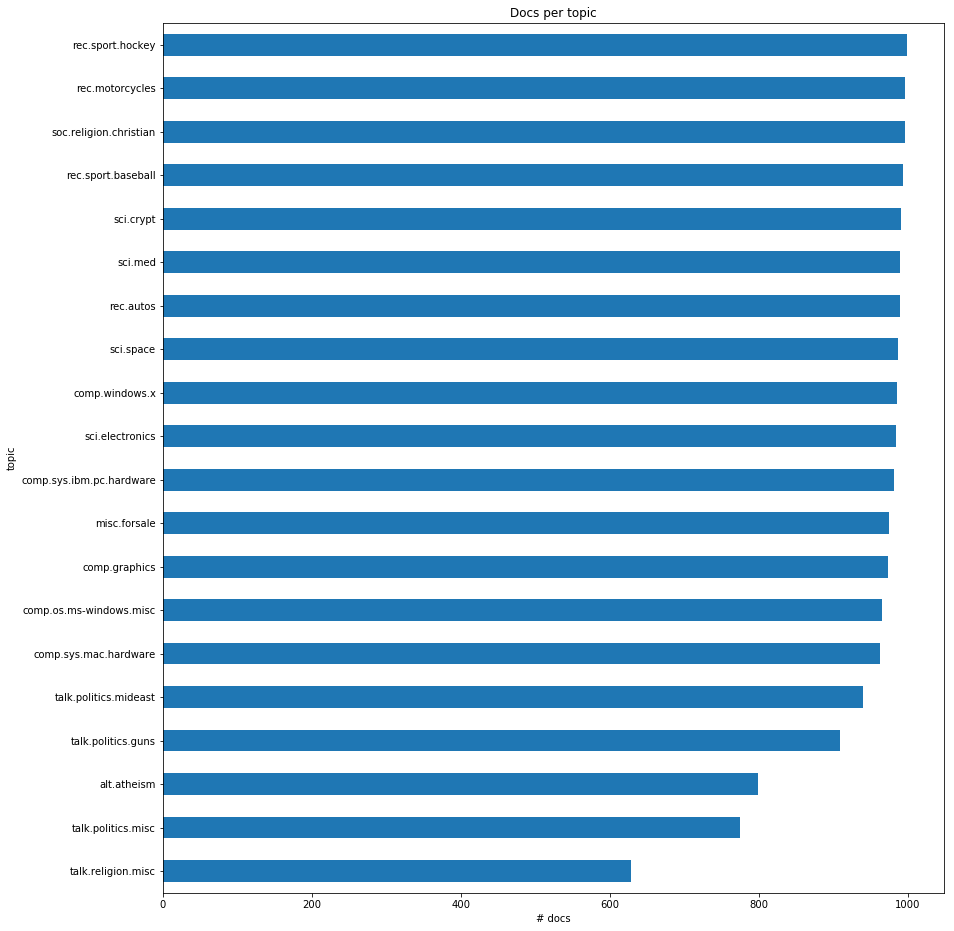

Getting dataset: ng20


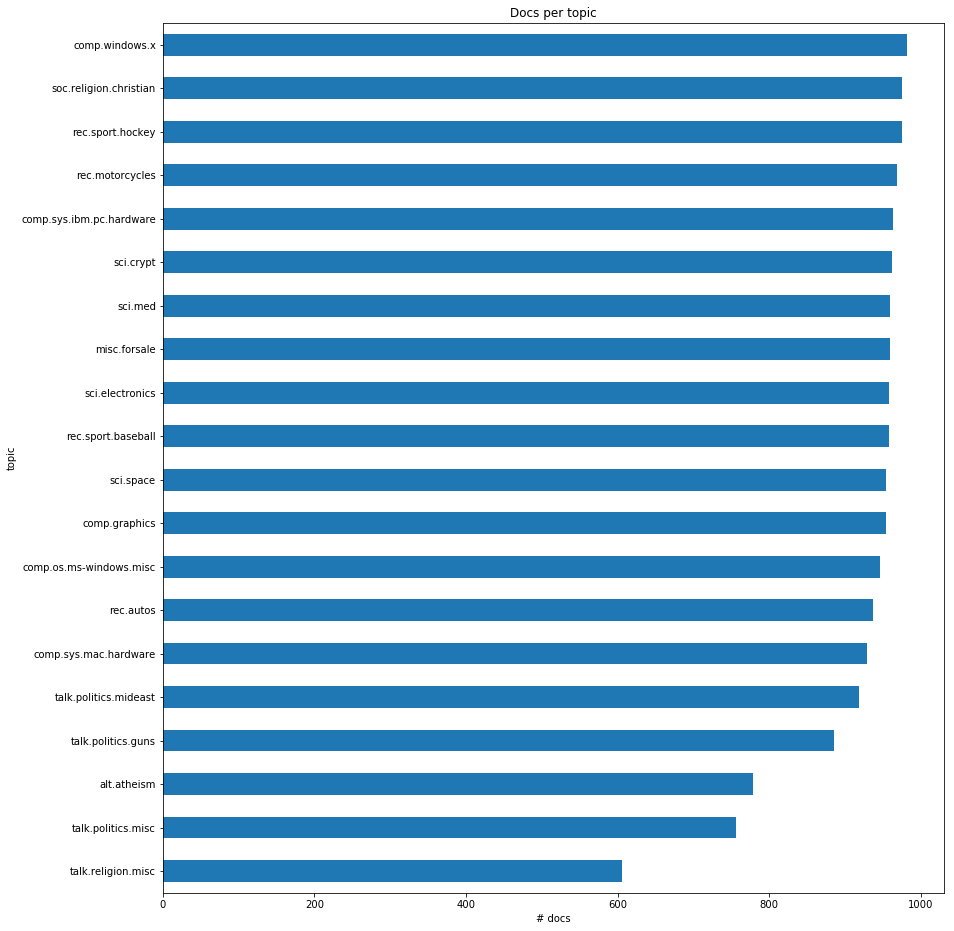

Getting dataset: r52-ana


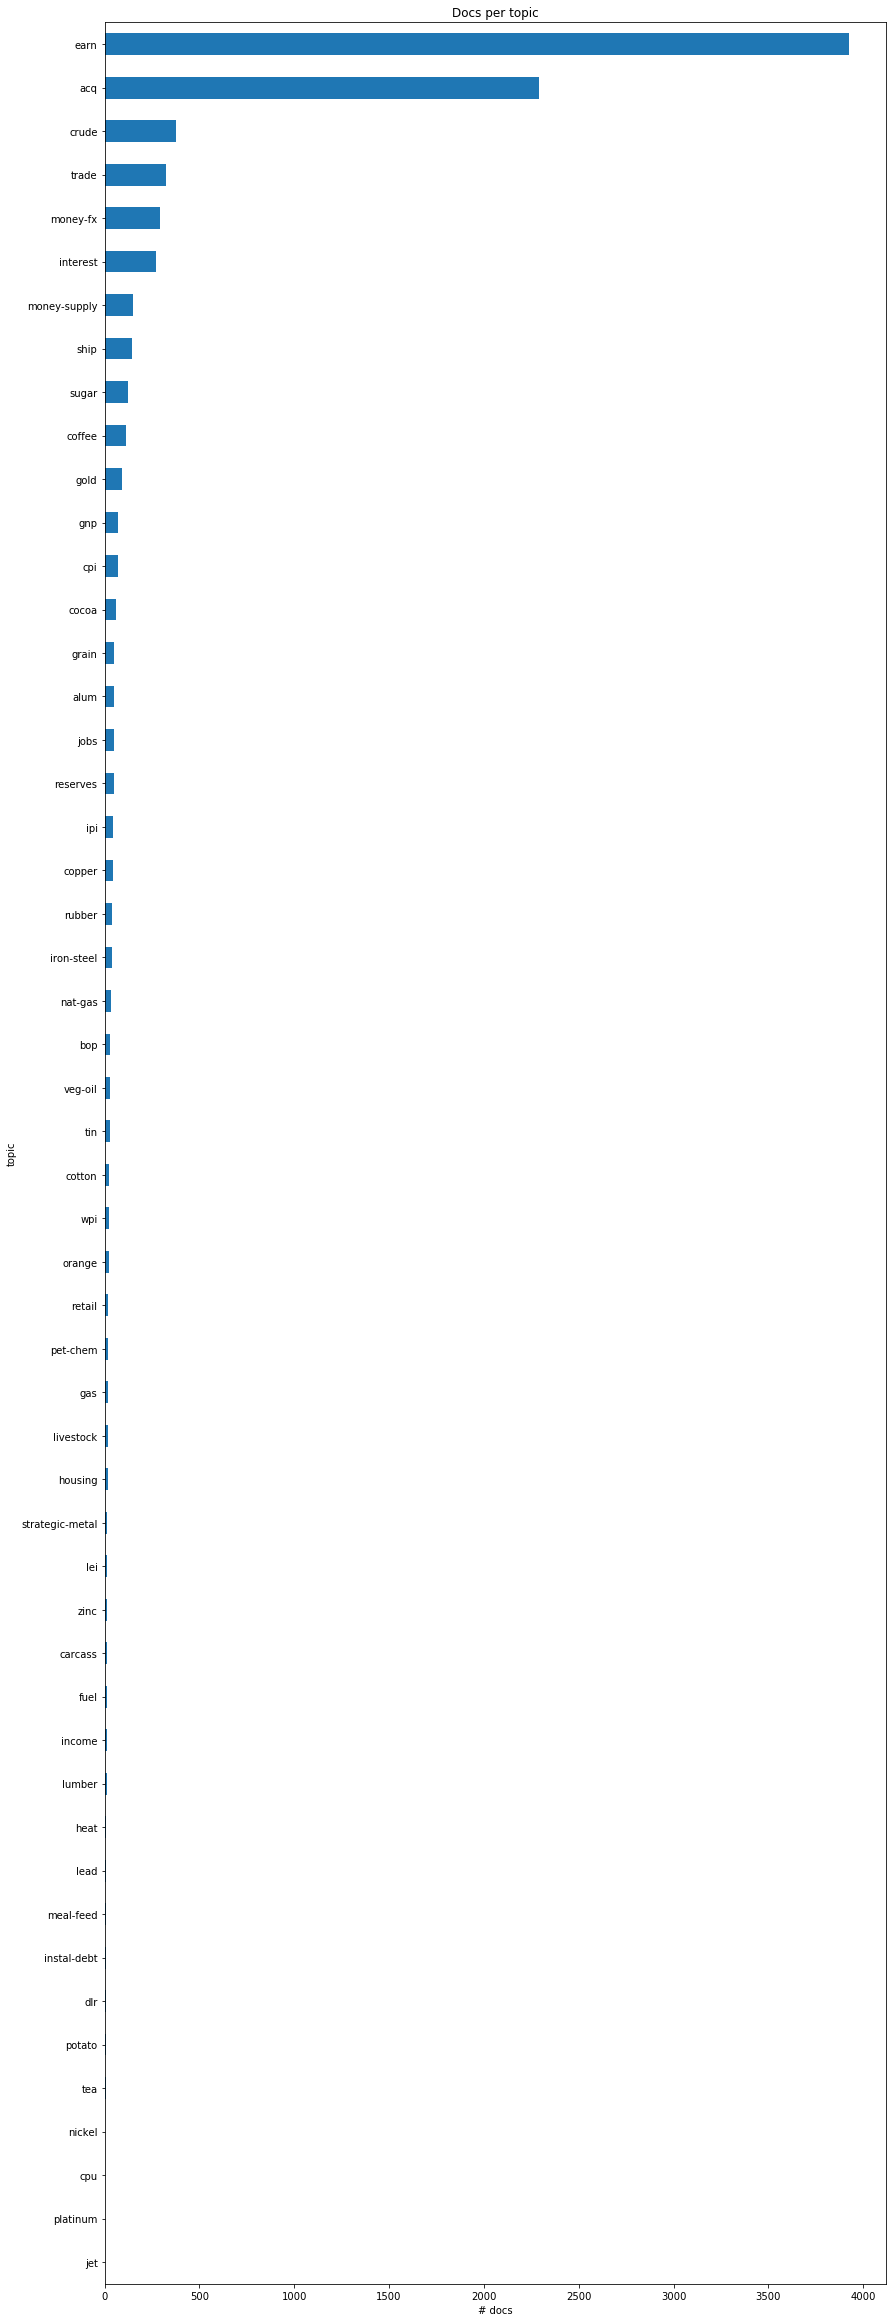

Getting dataset: r8-ana


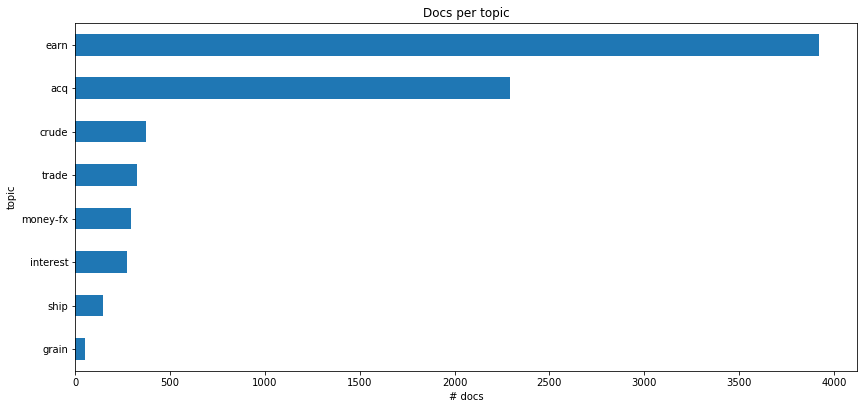

Getting dataset: r8


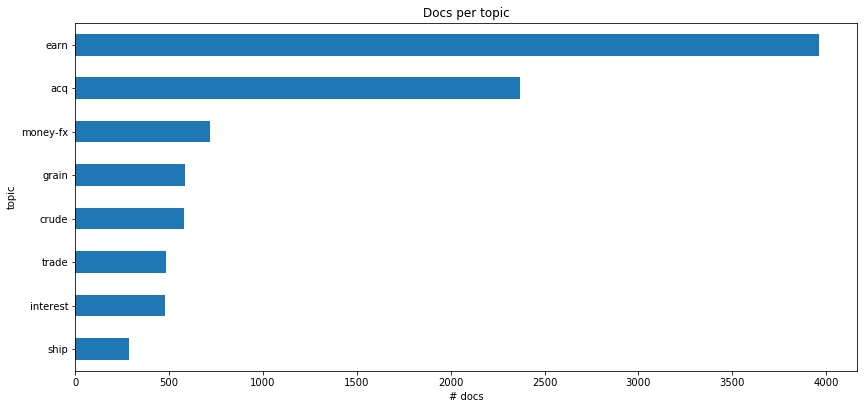

Getting dataset: webkb-ana


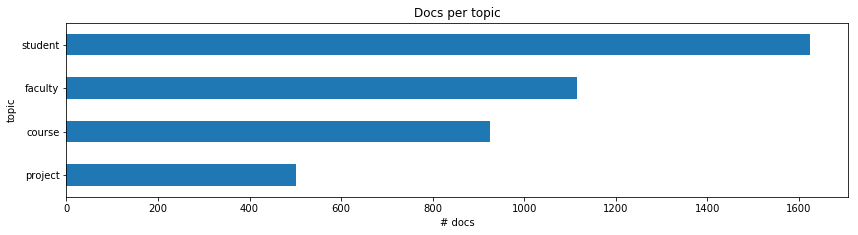

In [10]:
import dataset_helper
import matplotlib.pyplot as plt
for dataset in dataset_helper.get_all_available_dataset_names():
    print('Getting dataset: {}'.format(dataset))
    X, Y = dataset_helper.get_dataset(dataset)
    dataset_helper.plot_dataset_class_distribution(X, Y, title = 'Dataset: {}'.format(dataset), figsize = (14, len(set(Y)) * 0.8))
    plt.show()

In [ ]:
import functools
import wl
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix, csr_matrix, vstack

def get_all_nodes(gs):
    return functools.reduce(lambda acc, x: acc | set(x), gs, set())

def get_wl_args(graphs):
    adjs = [nx.adjacency_matrix(g).toarray() for g in graphs]
    nodes = [g.nodes() for g in graphs]
    return adjs, nodes


g1 = nx.DiGraph()
g1.add_edge('A', 'B')
g1.add_edge('B', 'C')

g2 = nx.DiGraph()
g2.add_edge('A', 'B')
g2.add_edge('B', 'C')
g2.add_edge('B', 'D')

g3 = nx.DiGraph()
g3.add_edge('E', 'F')
g3.add_node('G')
all_graphs = (g1, g2, g3)

DEBUG = False
H = 10

all_nodes = get_all_nodes((g1, g2, g3))

adjs, nodes = get_wl_args((g1, g2))
K_1_2, phi_1_2, label_lookups_1_2, label_counters_1_2 = wl.WL_compute(ad_list=adjs, node_label=nodes, all_nodes=all_nodes, h = H, DEBUG=DEBUG)
adjs, nodes = get_wl_args((g1, g2, g3))
K_1_2_3, phi_1_2_3, label_lookups_1_2_3, label_counters_1_2_3 = wl.WL_compute(ad_list=adjs, node_label=nodes, all_nodes=all_nodes, h = H, DEBUG=DEBUG)

TARGET_GRAPH = g3
K_1_2_3_test, phi_1_2_3_test = wl.WL_compute_new(
    ad_list=[nx.adjacency_matrix(TARGET_GRAPH).toarray()],
    node_label=[TARGET_GRAPH.nodes()],
    label_counters_prev = label_counters_1_2,
    all_nodes= all_nodes,
    h = H,
    k_prev = np.copy(K_1_2),
    phi_prev = np.copy(phi_1_2),
    label_lookups_prev = np.copy(label_lookups_1_2)
)

phi_3_test = wl.compute_phi(g3, phi_1_2_3[0].shape, label_lookups_1_2_3, label_counters_1_2_3, h = H)
for idx, (real, new) in enumerate(zip(phi_1_2_3, phi_3_test)):
    real = real[:,2]
    new = lil_matrix(new.reshape(-1,1))
    if not np.array_equiv(real.todense(), new.todense()):
        print('Phi not equal', idx)

if 0 == 1:
    for i, (a, b) in enumerate(zip(phi_1_2_3_test, phi_1_2_3)):
        if not np.array_equiv(a - b.todense(), np.zeros(b.shape, dtype = np.int32)):
            print("\tPhi different! {}".format(i))
            print(np.argwhere((a - b) != 0))

    for i, (a, b) in enumerate(zip(K_1_2_3_test, K_1_2_3)):
        if not np.array_equal(a, b):
            print(np.argwhere((a - b) != 0))
            print("\tK different! {}".format(i))


In [ ]:
if 0 == 1:
    def get_original_documents(DIR, ext = '/*/*.txt', whitelist = (), verbose = False):
        topics = collections.defaultdict(lambda: [])
        for file in helper.log_progress(list(sorted(glob(DIR + ext))), every = 100):
            topic_and_id = file.split('/')[-2]
            topic = topic_and_id.split('_')[0]
            if topic_and_id not in whitelist:
                if verbose: print('Ignoring: {} (not in whitelist)'.format(topic_and_id))
                continue
            with open(file) as f:
                topics[topic].append(f.read())
        return topics
    docs_per_topic = get_original_documents(ORIGINAL_DOCUMENTS_DIR, whitelist = graph_ids)